In [1]:
# Loading required packages
suppressMessages(library(tidyverse))
suppressMessages(library(tsibble))
suppressMessages(library(fable))
suppressMessages(library(tsibble))
suppressMessages(library(fabletools))
suppressMessages(library(feasts))
suppressMessages(library(lubridate))
suppressMessages(library(scales))
suppressMessages(library(fpp3))
suppressMessages(library(zoo))
suppressMessages(library(scales))
suppressMessages(library(forecast))

In [2]:
# Reading the CSV file into a DataFrame
iphone_data <- read.csv("/Users/sivabhaskar/Documents/690_TSF/Mid_Term_Project/iPhone Sales.csv")

# Displaying the top 5 rows of the dataframe
iphone_data %>% head()

,Time.Period,Sales....millions.,Units..millions.,Sales.Per.Unit
,<chr>,<int>,<dbl>,<dbl>
1,2007Q3,5,0.27,18.51852
2,2007Q4,118,1.12,105.35714
3,2008Q1,241,2.32,103.87931
4,2008Q2,378,1.70,222.35294
5,2008Q3,419,0.72,581.94444
6,2008Q4,806,6.89,116.98113


In [3]:
# Cleaning the dataframe by converting the date field as required
Iphone_Sales <- iphone_data %>%
    mutate(DATE = as.Date(as.yearqtr(Time.Period, format = "%YQ%q")), 
           SALES = as.numeric(Sales....millions.), 
           UNITS_SOLD = as.numeric(Units..millions.), 
           SALES_PER_UNIT = as.numeric(Sales.Per.Unit)) %>%
    group_by(DATE) %>%
    arrange(desc(DATE)) %>%
    mutate(INDEX = row_number()) %>%
    ungroup() %>%
    select(DATE, SALES, UNITS_SOLD, SALES_PER_UNIT) %>%
    arrange(DATE)

# Displaying the data in the dataframe after making the changes
Iphone_Sales %>% head()

DATE,SALES,UNITS_SOLD,SALES_PER_UNIT
<date>,<dbl>,<dbl>,<dbl>
2007-07-01,5,0.27,18.51852
2007-10-01,118,1.12,105.35714
2008-01-01,241,2.32,103.87931
2008-04-01,378,1.70,222.35294
2008-07-01,419,0.72,581.94444
2008-10-01,806,6.89,116.98113


In [4]:
# Converitng the dataframe to time-series data with quarterly frequency
Iphone_Sales_ts <- ts(Iphone_Sales$SALES, start=c(2007, 3), frequency = 4)


# Displaying the top rows of the dataframe after converting
Iphone_Sales_ts %>% head(10)

,Qtr1,Qtr2,Qtr3,Qtr4
2007,,,5,118
2008,241,378,419,806
2009,2940,2427,3060,4606


# Initial Basic Analysis of Iphone Sales Data

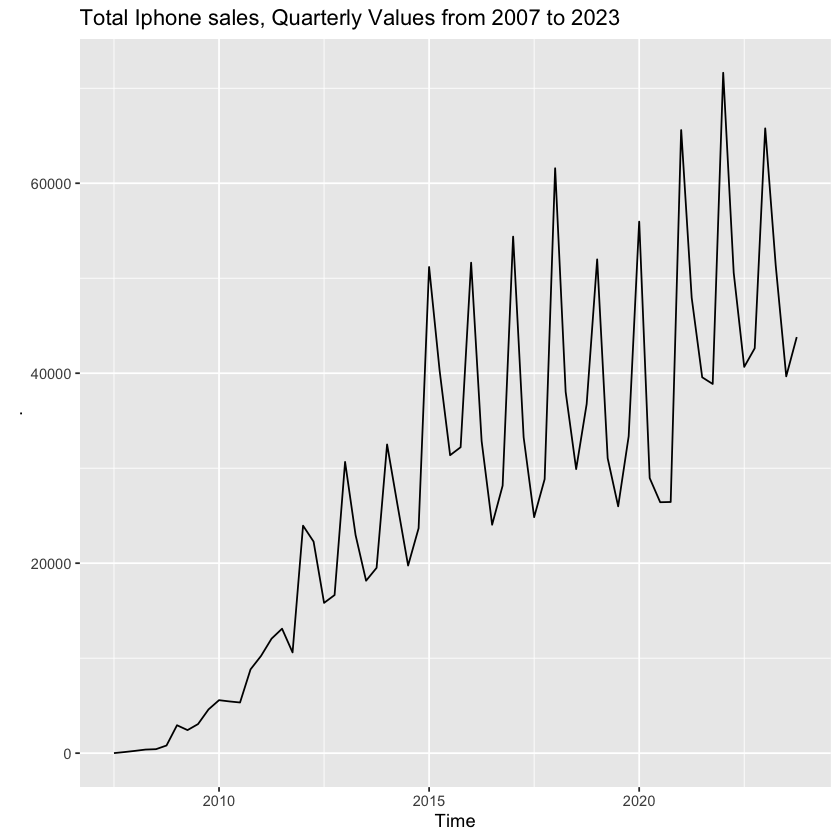

In [5]:
# Plotting the basic plot of the data using autoplot
Iphone_Sales_ts %>% autoplot() + ggtitle('Total Iphone sales, Quarterly Values from 2007 to 2023')

In [6]:
# Considering Iphone sales from 2011 as the data is much more stable when compared to initial years
Iphone_sales_from_2011 <- Iphone_Sales %>% 
              filter(year(DATE) >= 2011)

# Displaying the top rows of the dataframe
Iphone_sales_from_2011 %>% head()

DATE,SALES,UNITS_SOLD,SALES_PER_UNIT
<date>,<dbl>,<dbl>,<dbl>
2011-01-01,10239,16.24,630.4803
2011-04-01,12053,18.65,646.2735
2011-07-01,13102,20.34,644.1495
2011-10-01,10604,17.07,621.2068
2012-01-01,23950,37.04,646.5983
2012-04-01,22276,35.06,635.3679


In [7]:
# Converitng the dataframe to time-series data with quarterly frequency
Iphone_Sales_from_2011_ts <- ts(Iphone_sales_from_2011$SALES, start=c(2011, 1), frequency = 4)


# Displaying the top rows of the dataframe after converting
Iphone_Sales_from_2011_ts %>% head(10)

,Qtr1,Qtr2,Qtr3,Qtr4
2011,10239,12053,13102,10604
2012,23950,22276,15821,16645
2013,30660,22955,,


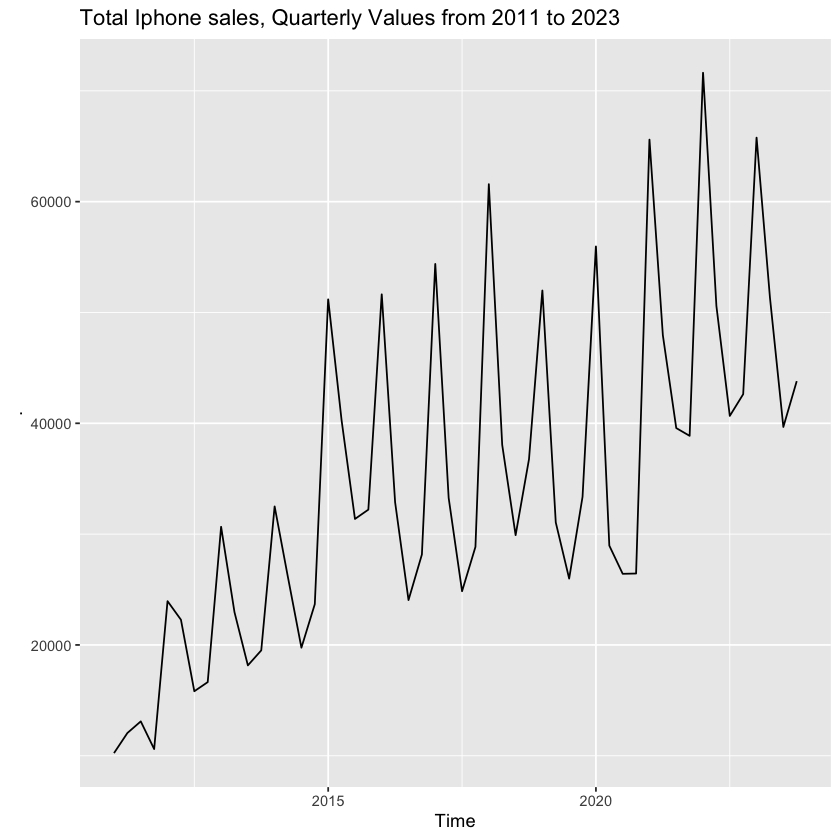

In [8]:
# Plotting the basic plot of the data using autoplot
Iphone_Sales_from_2011_ts %>% autoplot() + ggtitle('Total Iphone sales, Quarterly Values from 2011 to 2023')

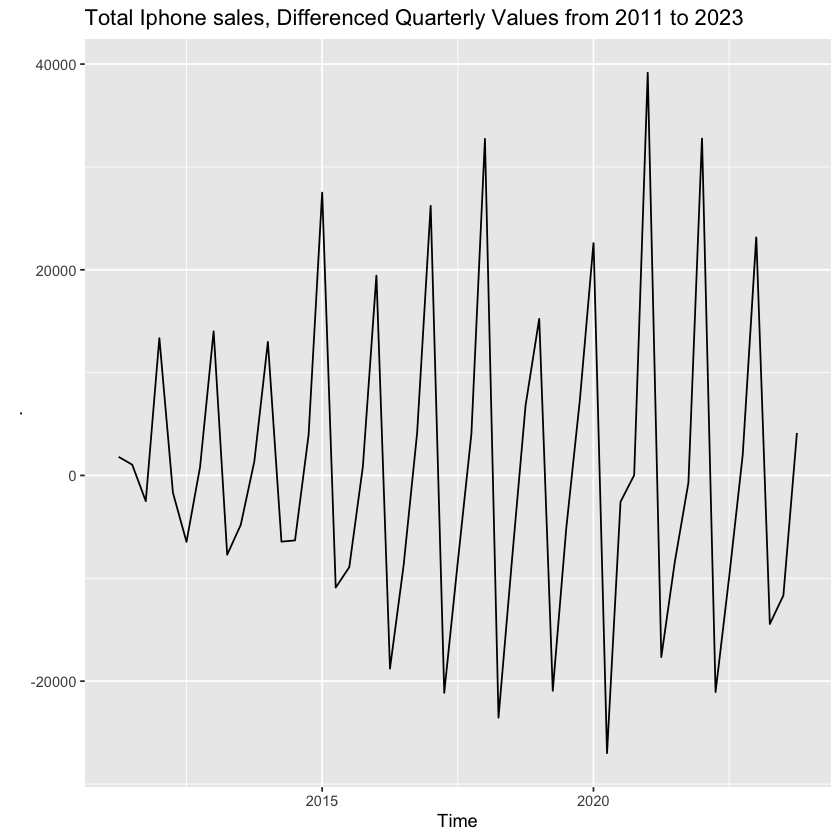

In [9]:
# Plotting the basic plot of the differenced quarter values data
Iphone_Sales_from_2011_ts %>% diff() %>% autoplot() + ggtitle('Total Iphone sales, Differenced Quarterly Values from 2011 to 2023')

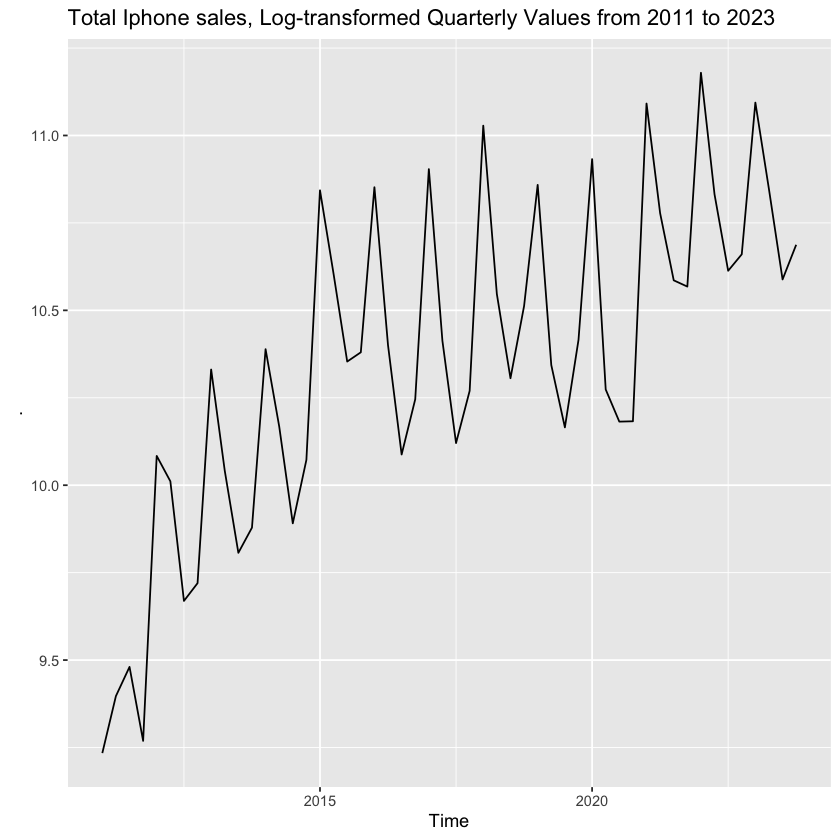

In [10]:
# Converting the original data to the log data 
logIphoneSales <- log(Iphone_Sales_from_2011_ts)

# Plotting the graph for transformed log data
logIphoneSales %>% autoplot() + ggtitle('Total Iphone sales, Log-transformed Quarterly Values from 2011 to 2023')

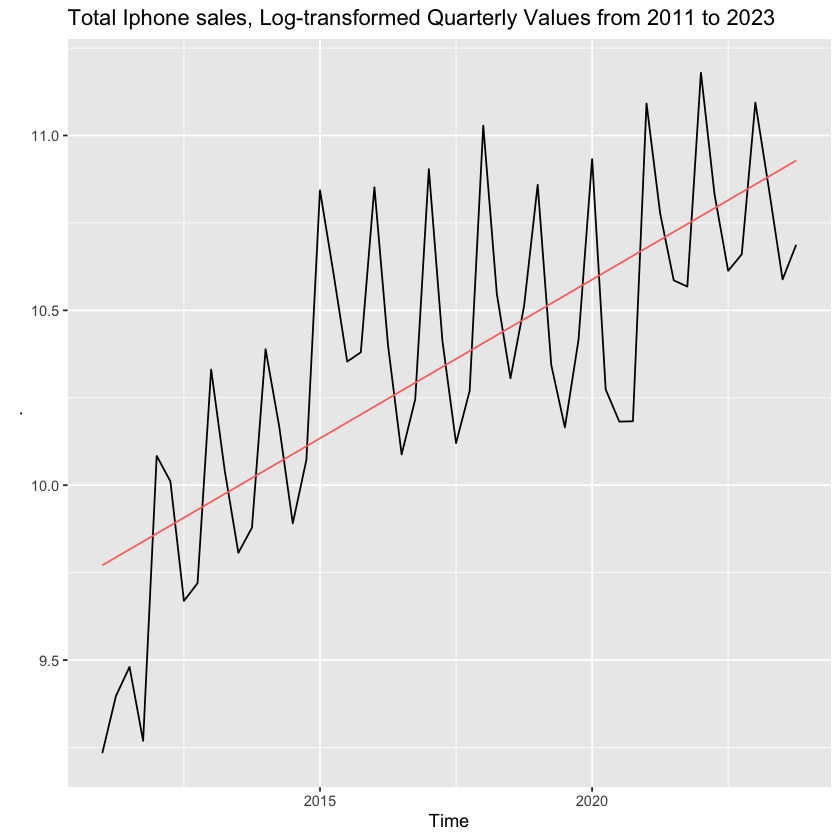

In [11]:
# Predicting the trend for the data
logIphoneSalesTrendModel <- tslm(logIphoneSales ~ trend) %>% 
                                predict(logIphoneSales) %>% 
                                ts(start=start(logIphoneSales), frequency=frequency(logIphoneSales))

# Plotting the predicted trend of the data over the log data graph
logIphoneSales %>% autoplot() +
                      autolayer(logIphoneSalesTrendModel, series='Linear Trend') +
                      theme(legend.position="none") +
                      ggtitle('Total Iphone sales, Log-transformed Quarterly Values from 2011 to 2023')

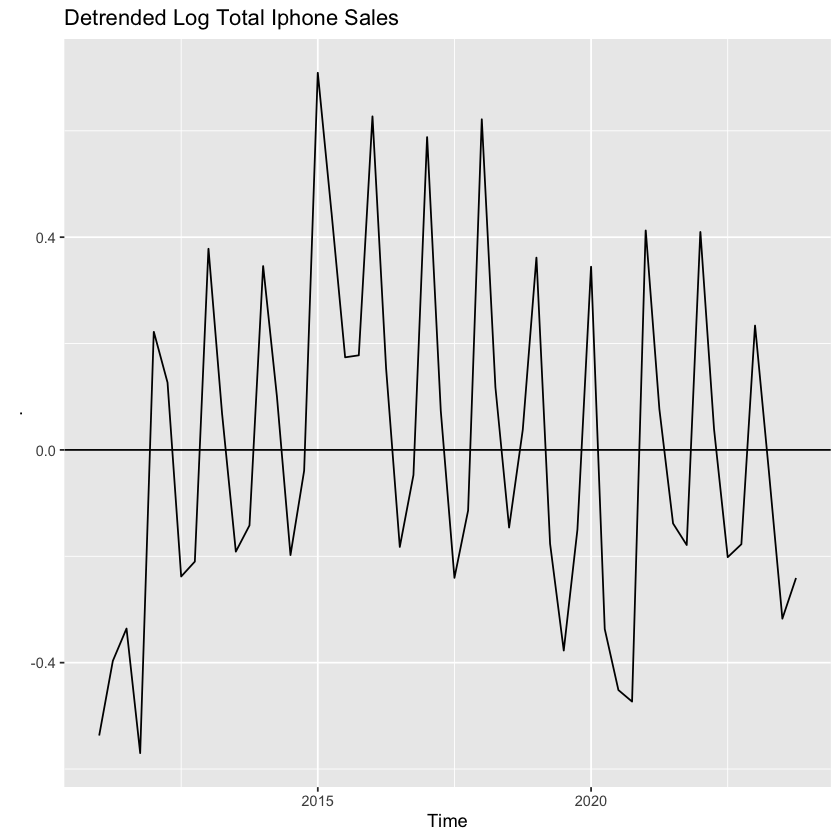

In [12]:
# Calculating the detrend
logIphoneSalesDetrend <- logIphoneSales - logIphoneSalesTrendModel

# Plotting the detrend of the data
detrendPlot <- logIphoneSalesDetrend %>% 
    autoplot() +
    ggtitle('Detrended Log Total Iphone Sales') +
    geom_hline(yintercept=0)

# Displaying the graph
detrendPlot

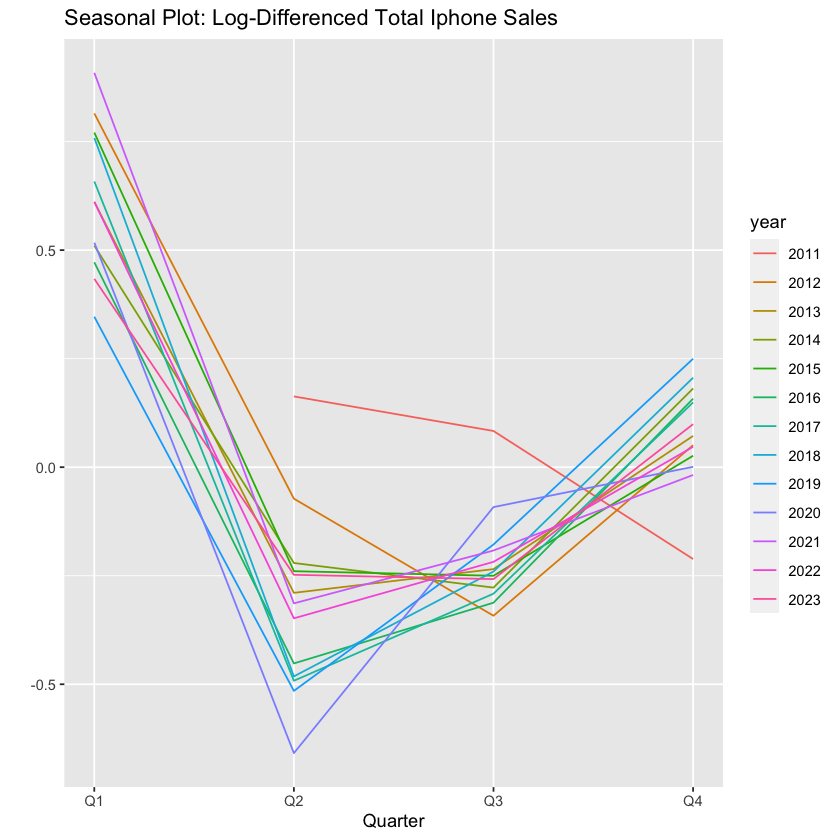

In [13]:
# Plotting the Seasonal Plot of the log data to identify any seasonality
logIphoneSales %>% diff() %>% ggseasonplot() + ggtitle('Seasonal Plot: Log-Differenced Total Iphone Sales')

# Estimating the missing Units Sold column values 

In [14]:
# Converting date using tsibble
iphone_data <- Iphone_sales_from_2011 %>% 
             mutate(DATE = yearmonth(floor_date(DATE, 'month'))) %>%
             group_by(DATE) |>
             as_tsibble(index=DATE)

# Displaying the top rows of the dataframe
iphone_data %>% head()

DATE,SALES,UNITS_SOLD,SALES_PER_UNIT
<mth>,<dbl>,<dbl>,<dbl>
2011 Jan,10239,16.24,630.4803
2011 Apr,12053,18.65,646.2735
2011 Jul,13102,20.34,644.1495
2011 Oct,10604,17.07,621.2068
2012 Jan,23950,37.04,646.5983
2012 Apr,22276,35.06,635.3679


In [15]:
# Splitting the data into train and test sets
iphone_data_tr <- iphone_data |> filter_index(. ~ '2017 Oct')
iphone_data_ts <- iphone_data |> filter_index('2018 Jan' ~ '2018 Oct')

In [16]:
# Displaying the bottom rows of the dataframe
iphone_data_ts |> tail()

DATE,SALES,UNITS_SOLD,SALES_PER_UNIT
<mth>,<dbl>,<dbl>,<dbl>
2018 Jan,61576,77.3,796.5847
2018 Apr,38032,52.2,728.5824
2018 Jul,29906,41.3,724.1162
2018 Oct,36755,46.9,783.6887


In [17]:
# Checking various models to see which performs best
iphone_data_mdl <- iphone_data_tr |>
model(
    'NAIVE Model' = NAIVE(UNITS_SOLD),
    'Trend' = TSLM(UNITS_SOLD ~ trend()),
    'Seasonal Trend' = TSLM(UNITS_SOLD ~ trend() + season()),
    'SNAIVE Model' = SNAIVE(UNITS_SOLD ~ lag('1 year')),
    'Random Walk' = RW(UNITS_SOLD ~ drift()),
    'ES Model' = ETS(UNITS_SOLD),
)

# Displaying the reports of the models
iphone_data_mdl |> accuracy() |> select(.model, ME, RMSE, MAPE, ACF1)

.model,ME,RMSE,MAPE,ACF1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
NAIVE Model,1.127407e+00,15.523964,24.896269,-0.2188700
Trend,5.075305e-16,11.615038,22.978142,0.1101399
Seasonal Trend,2.410770e-15,7.199230,16.018901,0.4304254
SNAIVE Model,6.019167e+00,9.951756,17.913321,0.6140132
Random Walk,1.480297e-15,15.482972,25.037063,-0.2188700
ES Model,-1.624057e+00,5.371352,9.495352,0.2636509


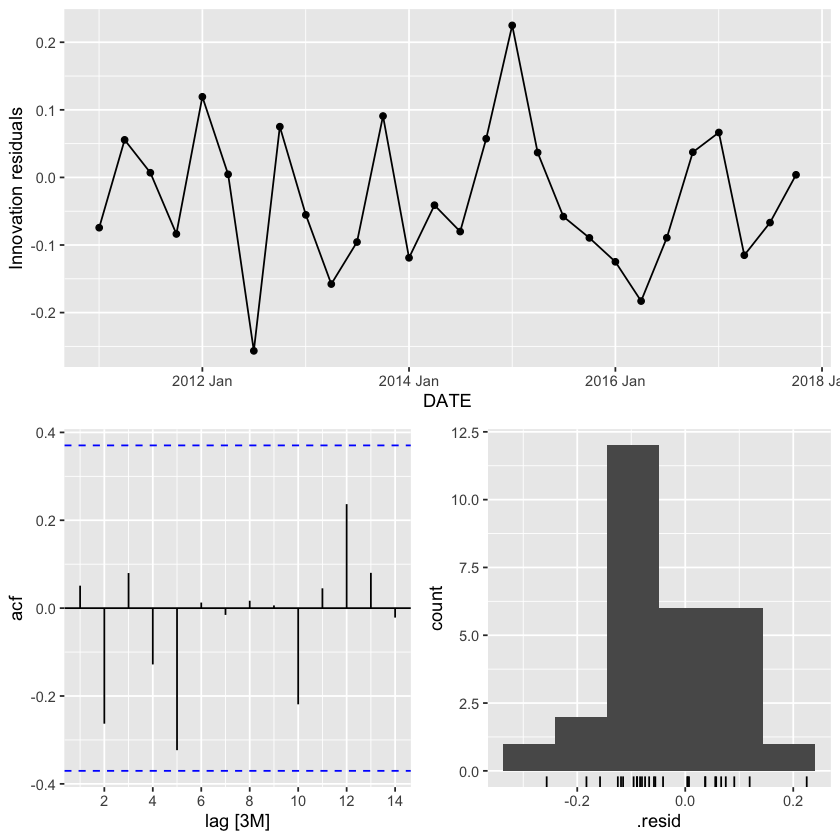

In [18]:
# Checking the redsiduals
iphone_data_mdl |> select(`ES Model`) |> gg_tsresiduals()

Warning message:
“Removed 4 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_bin()`).”


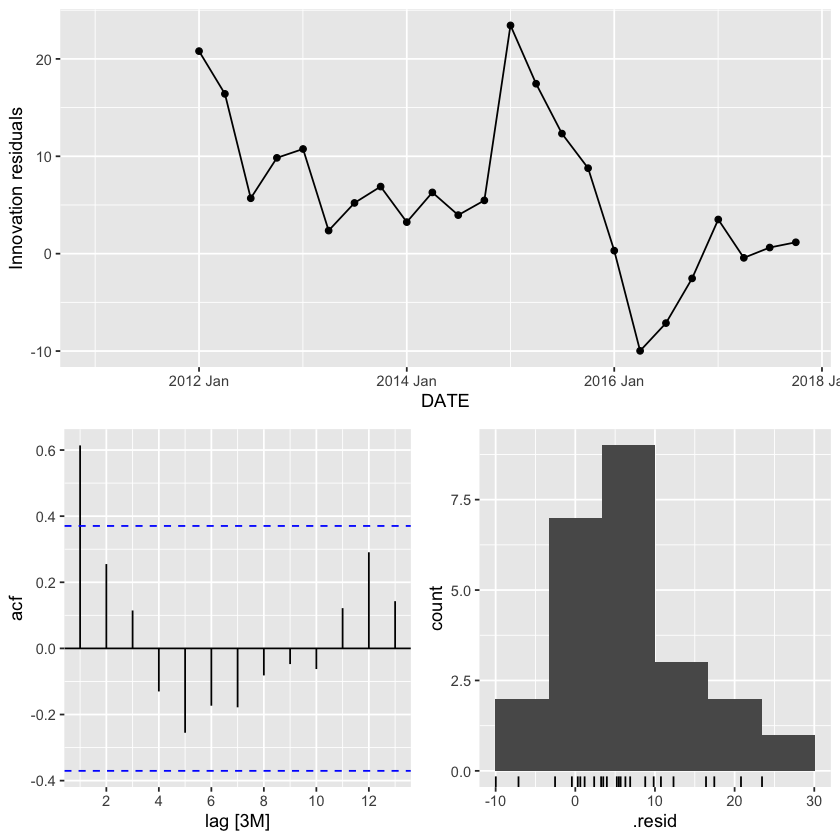

In [19]:
# Checking the redsiduals
iphone_data_mdl |> select(`SNAIVE Model`) |> gg_tsresiduals()

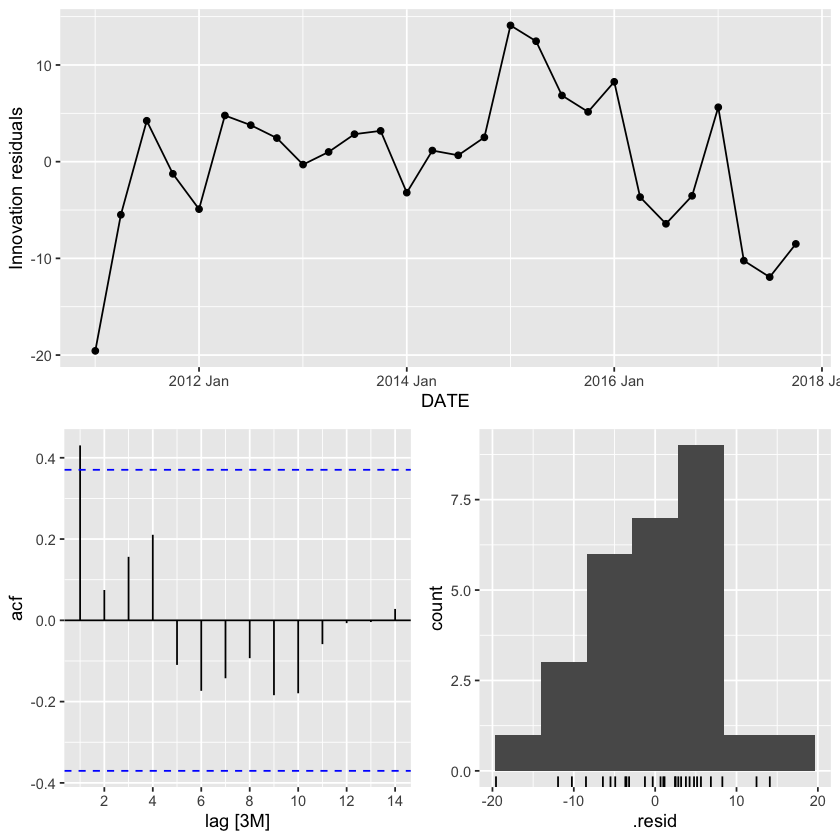

In [20]:
# Checking the redsiduals
iphone_data_mdl |> select(`Seasonal Trend`) |> gg_tsresiduals()

In [21]:
# Forecasting for the test data to see which model performs best
iphone_data_mdl_forecasts <- iphone_data_mdl |>
forecast(iphone_data_ts)

# Displaying the reports
iphone_data_mdl_forecasts |>
accuracy(iphone_data_ts) |>
select(.model, ME, RMSE, MAPE, ACF1)

.model,ME,RMSE,MAPE,ACF1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ES Model,-1.435960,1.9791636,3.515282,0.300215067
NAIVE Model,7.745000,15.7880303,15.920583,0.101797796
Random Walk,4.926481,15.6177136,18.692732,0.123024791
SNAIVE Model,0.235000,0.8909265,1.290545,-0.485587827
Seasonal Trend,-12.171429,13.7010846,26.114776,-0.007536082
Trend,-9.847343,18.0043470,35.035458,0.127407403


Warning message:
“Removed 20 rows containing missing values (`geom_line()`).”


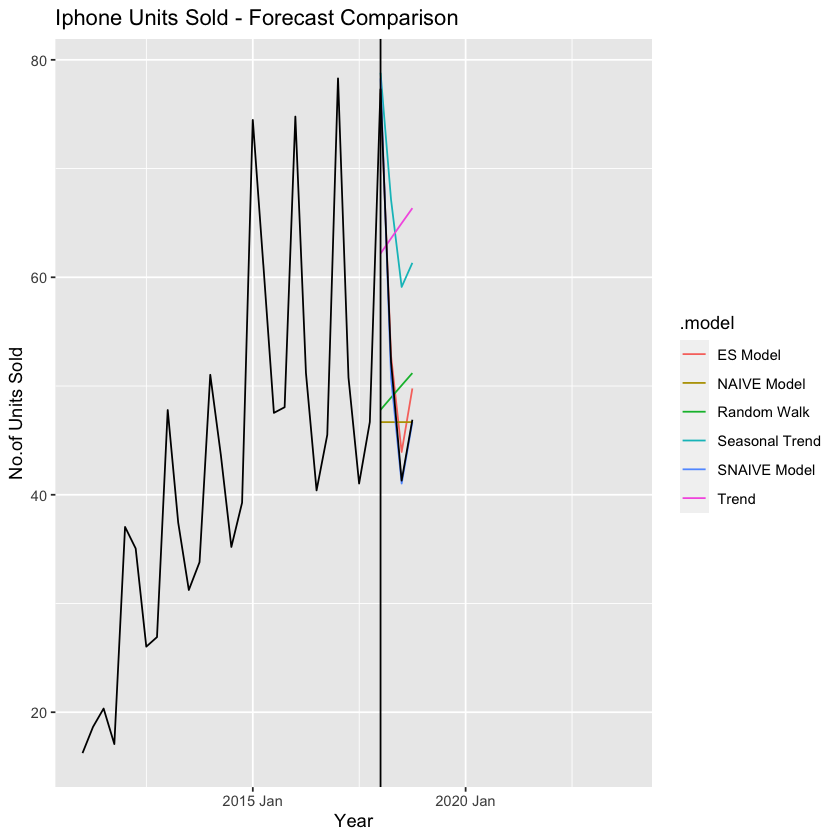

In [22]:
# Plotting the forecast graphs of models
iphone_data_mdl_forecasts |>
autoplot(level=NULL) +
autolayer(iphone_data |> filter_index('2011 Jan' ~ .), UNITS_SOLD) +
geom_vline(xintercept = as.Date('2018-01-01')) +
labs(title='Iphone Units Sold - Forecast Comparison', x='Year', y='No.of Units Sold')

In [23]:
# Displaying the forecast values of our best model
iphone_data_forecasts <- iphone_data_mdl_forecasts |>
filter(.model == 'SNAIVE Model') |>
as.data.frame() |>
select(DATE, .mean) |>
rename(UNITS_SOLD = .mean) |>
as_tsibble(index=DATE)

# Displaying the forecast values
iphone_data_forecasts

DATE,UNITS_SOLD
<mth>,<dbl>
2018 Jan,78.29
2018 Apr,50.76
2018 Jul,41.03
2018 Oct,46.68


In [24]:
# Updating the data with forecast values
corrected_iphone_data <- iphone_data_tr |>
select(DATE, UNITS_SOLD) |>
bind_rows(iphone_data_forecasts)

# Displaying the bottom rows of the data
corrected_iphone_data %>% tail()

DATE,UNITS_SOLD
<mth>,<dbl>
2017 Jul,41.03
2017 Oct,46.68
2018 Jan,78.29
2018 Apr,50.76
2018 Jul,41.03
2018 Oct,46.68


In [25]:
# Forecasting for the future 8 time periods using our best model
iphone_data_fc <- corrected_iphone_data |>
model(
    'SNAIVE Model' = SNAIVE(UNITS_SOLD ~ lag('1 year'))
) |>
forecast(h = 8) |>
as.data.frame() |>
select(DATE, .mean) |>
rename(UNITS_SOLD = .mean) |>
as_tsibble(index=DATE)

# Displaying the bottom rows of the data
iphone_data_fc %>% tail()

DATE,UNITS_SOLD
<mth>,<dbl>
2019 Jul,41.03
2019 Oct,46.68
2020 Jan,78.29
2020 Apr,50.76
2020 Jul,41.03
2020 Oct,46.68


In [26]:
# Updating the data with forecast values
corrected_iphone_data <- corrected_iphone_data |>
select(DATE, UNITS_SOLD) |>
bind_rows(iphone_data_fc)

# Displaying the bottom rows of the data
corrected_iphone_data  %>% tail()

DATE,UNITS_SOLD
<mth>,<dbl>
2019 Jul,41.03
2019 Oct,46.68
2020 Jan,78.29
2020 Apr,50.76
2020 Jul,41.03
2020 Oct,46.68


In [27]:
# Splitting the data into train and test sets
c_iphone_data_tr <- corrected_iphone_data |> filter_index(. ~ '2019 Oct')
c_iphone_data_ts <- corrected_iphone_data |> filter_index('2020 Jan' ~ '2020 Oct')

In [28]:
# Checking various models to see which performs best
iphone_data_mdl <- c_iphone_data_tr |>
model(
    'NAIVE Model' = NAIVE(UNITS_SOLD),
    'Trend' = TSLM(UNITS_SOLD ~ trend()),
    'Seasonal Trend' = TSLM(UNITS_SOLD ~ trend() + season()),
    'SNAIVE Model' = SNAIVE(UNITS_SOLD ~ lag('1 year')),
    'Random Walk' = RW(UNITS_SOLD ~ drift()),
    'ES Model' = ETS(UNITS_SOLD),
)

# Displaying the reports of the models
iphone_data_mdl |> accuracy() |> select(.model, ME, RMSE, MAPE, ACF1)

.model,ME,RMSE,MAPE,ACF1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
NAIVE Model,8.697143e-01,17.133260,26.658790,-0.2310585
Trend,1.924387e-15,13.082400,25.157890,0.1392055
Seasonal Trend,3.454027e-15,8.320187,17.527423,0.5066850
SNAIVE Model,4.514375e+00,8.618474,13.434991,0.6496214
Random Walk,-1.141944e-15,17.111171,26.737002,-0.2310585
ES Model,-7.349882e-01,4.629227,7.594775,0.2134866


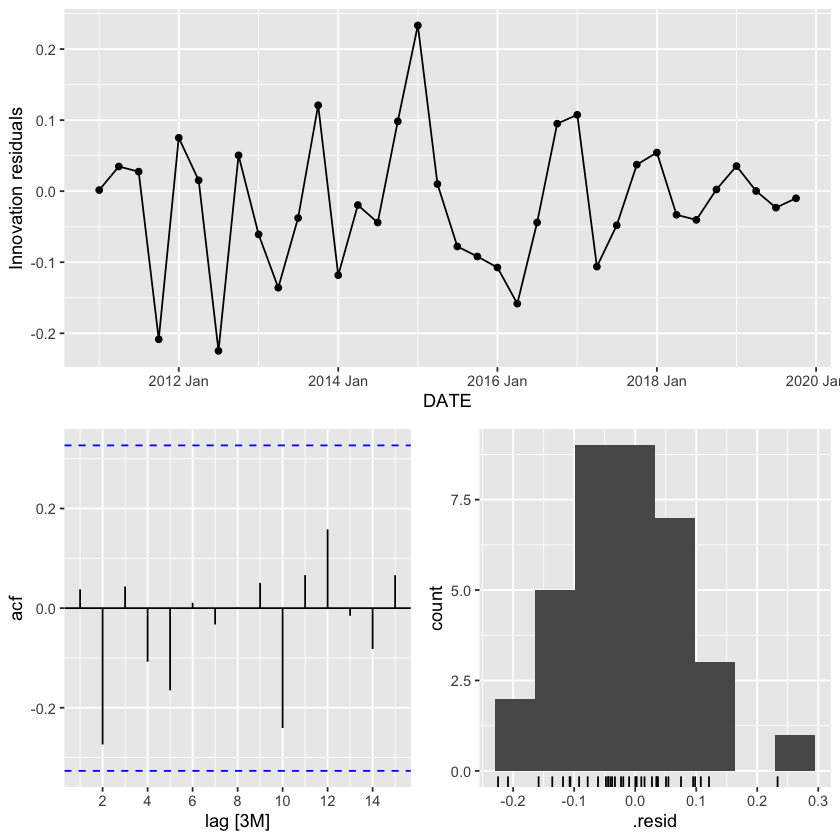

In [29]:
# Checking the residuals
iphone_data_mdl |> select(`ES Model`) |> gg_tsresiduals()

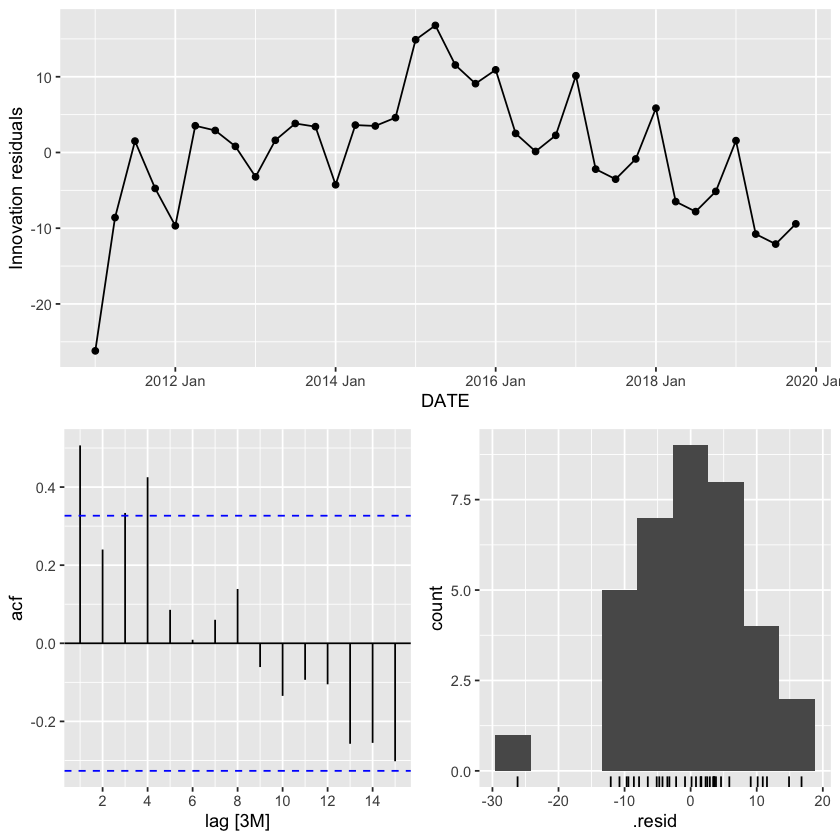

In [30]:
# Checking the residuals
iphone_data_mdl |> select(`Seasonal Trend`) |> gg_tsresiduals()

Warning message:
“Removed 4 rows containing missing values (`geom_line()`).”
Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 4 rows containing non-finite values (`stat_bin()`).”


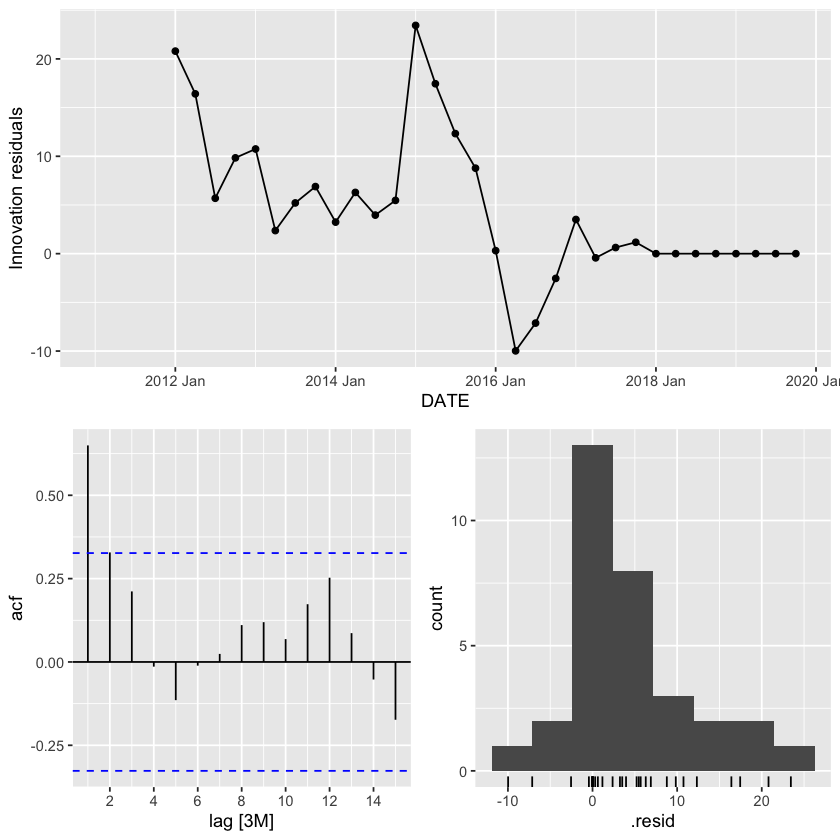

In [31]:
# Checking the residuals
iphone_data_mdl |> select(`SNAIVE Model`) |> gg_tsresiduals()

In [32]:
# Forecasting for the test data to see which model performs best
iphone_data_mdl_forecasts <- iphone_data_mdl |>
forecast(c_iphone_data_ts)

# Displaying the reports
iphone_data_mdl_forecasts |>
accuracy(c_iphone_data_ts) |>
select(.model, ME, RMSE, MAPE, ACF1)

.model,ME,RMSE,MAPE,ACF1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ES Model,0.7792973,0.8620768,1.394619,0.30798939
NAIVE Model,7.5100000,16.1845683,15.545941,0.07456864
Random Walk,5.3357143,16.0527204,17.864445,0.09211790
SNAIVE Model,0.0000000,0.0000000,0.000000,NaN
Seasonal Trend,-11.9681944,13.1391000,25.610410,-0.06165238
Trend,-10.0922179,18.2796497,36.038663,0.09413603


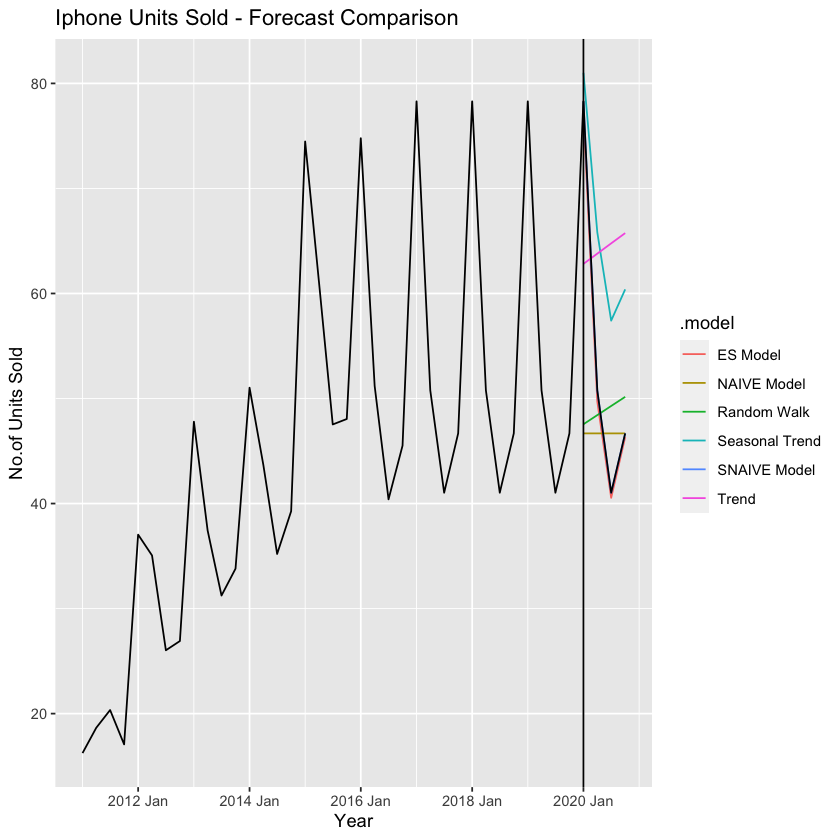

In [33]:
# Plotting the forecast graphs of models
iphone_data_mdl_forecasts |>
autoplot(level=NULL) +
autolayer(corrected_iphone_data |> filter_index('2011 Jan' ~ .), UNITS_SOLD) +
geom_vline(xintercept = as.Date('2020-01-01')) +
labs(title='Iphone Units Sold - Forecast Comparison', x='Year', y='No.of Units Sold')

In [34]:
# Displaying the forecast values of our best model
iphone_data_forecasts <- iphone_data_mdl_forecasts |>
filter(.model == 'ES Model') |>
as.data.frame() |>
select(DATE, .mean) |>
rename(UNITS_SOLD = .mean) |>
as_tsibble(index=DATE)

# Displaying the bottom rows of the data
iphone_data_forecasts %>% tail()

DATE,UNITS_SOLD
<mth>,<dbl>
2020 Jan,77.06324
2020 Apr,49.70732
2020 Jul,40.54513
2020 Oct,46.32712


In [35]:
# Updating the data with forecast values
corrected_iphone_data <- c_iphone_data_tr |>
select(DATE, UNITS_SOLD) |>
bind_rows(iphone_data_forecasts)

# Displaying the bottom rows of the data
corrected_iphone_data %>% tail()

DATE,UNITS_SOLD
<mth>,<dbl>
2019 Jul,41.03000
2019 Oct,46.68000
2020 Jan,77.06324
2020 Apr,49.70732
2020 Jul,40.54513
2020 Oct,46.32712


In [36]:
# Forecasting for the future 12 time periods using our best model
iphone_data_fc <- corrected_iphone_data |>
model(
    'ES Model' = ETS(UNITS_SOLD)
) |>
forecast(h = 12) |>
as.data.frame() |>
select(DATE, .mean) |>
rename(UNITS_SOLD = .mean) |>
as_tsibble(index=DATE)

# Displaying the bottom rows of the data
iphone_data_fc %>% tail(12)

DATE,UNITS_SOLD
<mth>,<dbl>
2021 Jan,76.86629
2021 Apr,49.82943
2021 Jul,40.67580
2021 Oct,46.45524
2022 Jan,77.23511
2022 Apr,50.05453
2022 Jul,40.84945
2022 Oct,46.64335
2023 Jan,77.53264


In [37]:
# Updating the data with forecast values
corrected_iphone_data <- corrected_iphone_data |>
select(DATE, UNITS_SOLD) |>
bind_rows(iphone_data_fc)

# Displaying the bottom rows of the data
corrected_iphone_data %>% tail()

DATE,UNITS_SOLD
<mth>,<dbl>
2022 Jul,40.84945
2022 Oct,46.64335
2023 Jan,77.53264
2023 Apr,50.23876
2023 Jul,40.99359
2023 Oct,46.80166


In [38]:
# Aggregating the original iphone data with the updated units sold data to fill the missing data
updated_iphone_data <- iphone_data %>% 
                    left_join(corrected_iphone_data, by='DATE') %>%
                    mutate(UNITS_SOLD = round(UNITS_SOLD.y, digits = 2)) %>%
                    mutate(SALES_PER_UNIT = SALES / UNITS_SOLD.y) %>%
                    select(DATE, SALES, UNITS_SOLD, SALES_PER_UNIT)

# Displaying the updated data
updated_iphone_data |> tail(8)

DATE,SALES,UNITS_SOLD,SALES_PER_UNIT
<mth>,<dbl>,<dbl>,<dbl>
2022 Jan,71628,77.24,927.4021
2022 Apr,50570,50.05,1010.2981
2022 Jul,40665,40.85,995.4847
2022 Oct,42626,46.64,913.8709
2023 Jan,65775,77.53,848.3523
2023 Apr,51334,50.24,1021.8006
2023 Jul,39669,40.99,967.6880
2023 Oct,43805,46.80,935.9711


In [39]:
# Splitting the data into train and test sets
iphone_tr <- updated_iphone_data |> filter_index(. ~ '2022 Oct')
iphone_ts <- updated_iphone_data |> filter_index('2022 Jan' ~ '2022 Oct')

In [40]:
# Checking various models to see which performs best
iphone_sales_mdl <- iphone_tr |>
model(
    'Trend' = TSLM(SALES ~ trend()),
    'Seasonal Trend' = TSLM(SALES ~ trend() + season()),
    'Seasonal Trend Units_Sold' = TSLM(SALES ~ trend() + season() + UNITS_SOLD),
    'SNAIVE Model' = SNAIVE(SALES),
    'ES Model' = ETS(SALES),
    'Naive' = NAIVE(SALES),
    'MEAN' = MEAN(SALES)
)

# Displaying the reports of the models
iphone_sales_mdl |> report() |> select(.model, r_squared, AICc)

Warning message in report.mdl_df(iphone_sales_mdl):
“Model reporting is only supported for individual models, so a glance will be shown. To see the report for a specific model, use `select()` and `filter()` to identify a single model.”


.model,r_squared,AICc
<chr>,<dbl>,<dbl>
Trend,0.4301813,899.1332
Seasonal Trend,0.8034365,855.5486
Seasonal Trend Units_Sold,0.9140033,818.6193
SNAIVE Model,NA,NA
ES Model,NA,1014.5785
Naive,NA,NA
MEAN,NA,NA


In [41]:
# Displaying the reports of the models
iphone_sales_mdl |> accuracy() |> select(.model, ME, RMSE, MAPE, ACF1)

.model,ME,RMSE,MAPE,ACF1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Trend,-9.094947e-13,10913.865,27.69364,0.02765682
Seasonal Trend,1.534772e-12,6410.054,18.27891,0.38152914
Seasonal Trend Units_Sold,9.000208e-13,4239.856,11.64804,0.53793265
SNAIVE Model,3.624795e+03,7626.580,17.80287,0.58159330
ES Model,-8.842947e+02,5067.103,11.93997,0.22443028
Naive,6.890851e+02,15332.138,31.42664,-0.26261829
MEAN,-3.221127e-12,14458.068,44.75577,0.41869495


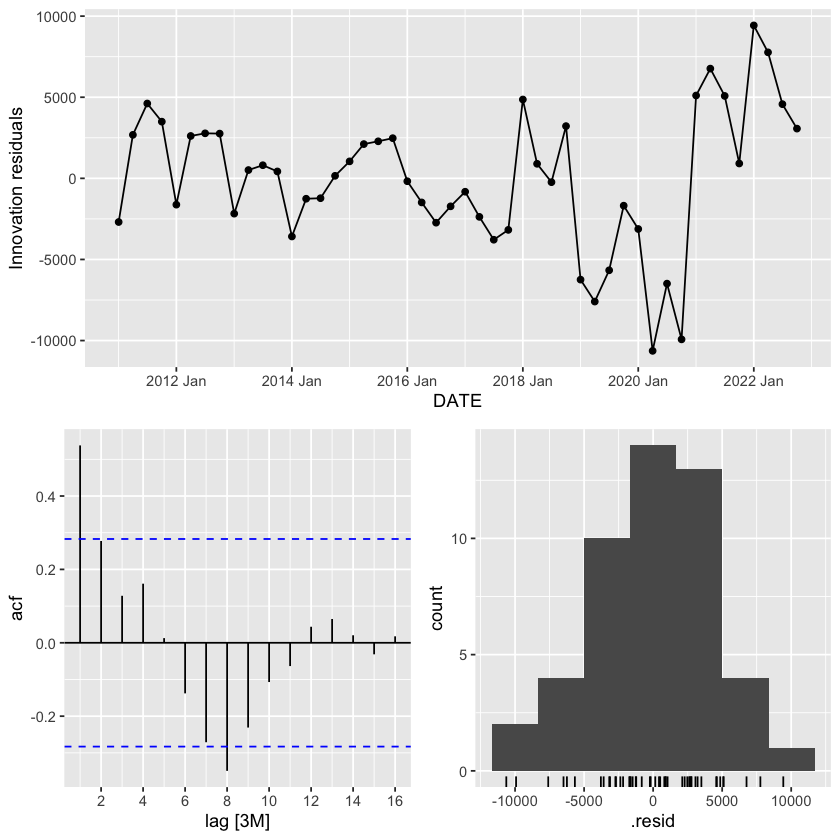

In [42]:
# Checking the residuals
iphone_sales_mdl |> select(`Seasonal Trend Units_Sold`) |> gg_tsresiduals()

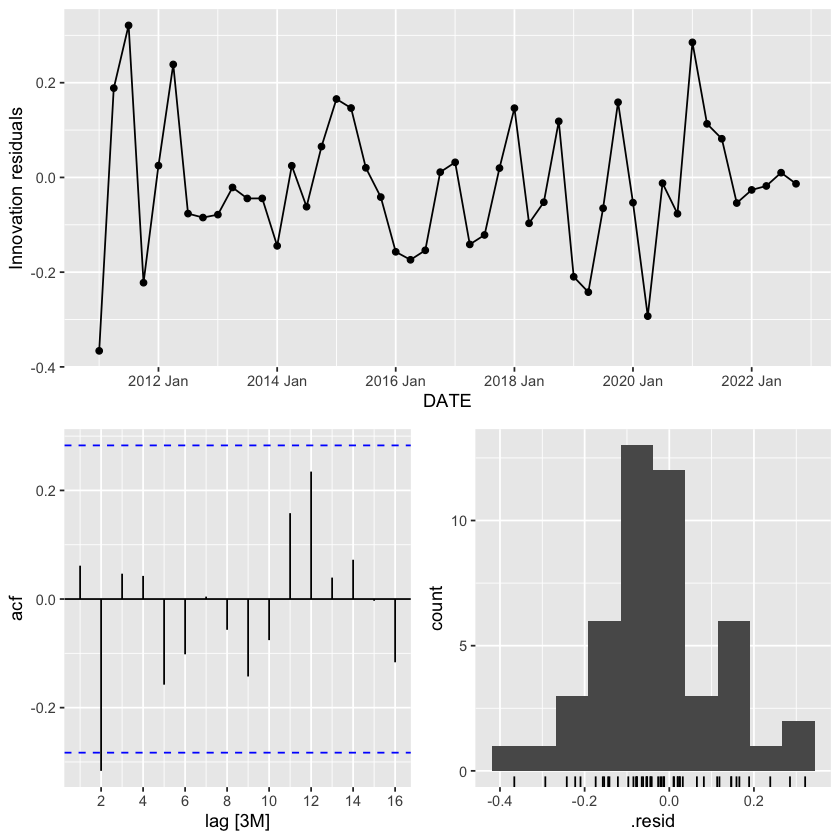

In [43]:
# Checking the residuals
iphone_sales_mdl |> select(`ES Model`) |> gg_tsresiduals()

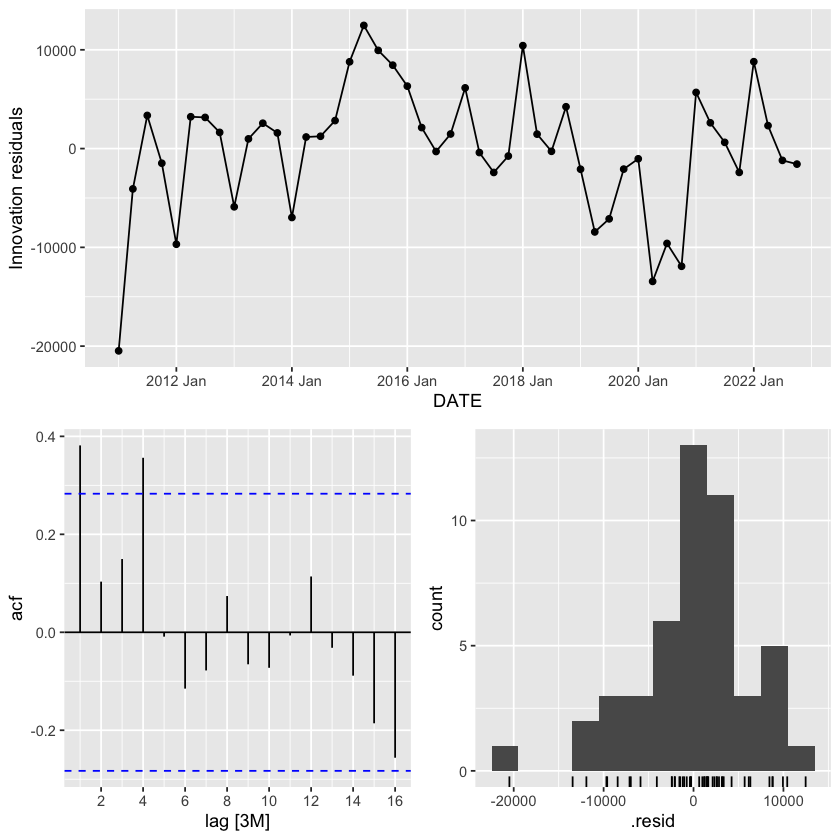

In [44]:
# Checking the residuals
iphone_sales_mdl |> select(`Seasonal Trend`) |> gg_tsresiduals()

In [45]:
# Forecasting for the test data and checking the reports
iphone_sales_mdl_forecasts <- iphone_sales_mdl |>
forecast(iphone_ts)

# Displaying the reports
iphone_sales_mdl_forecasts |> accuracy(iphone_ts) |> select(.model, ME, RMSE, MAPE, ACF1)

.model,ME,RMSE,MAPE,ACF1
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ES Model,-5400.150,5592.006,10.443788,0.1795503
MEAN,18144.896,21903.368,32.061173,0.1428180
Naive,8746.250,15067.089,15.255250,0.1428180
SNAIVE Model,0.000,0.000,0.000000,NaN
Seasonal Trend,2088.660,4655.764,5.875631,0.1851422
Seasonal Trend Units_Sold,6208.715,6699.699,11.740254,0.3002199
Trend,3085.680,13312.082,18.621260,0.1539743


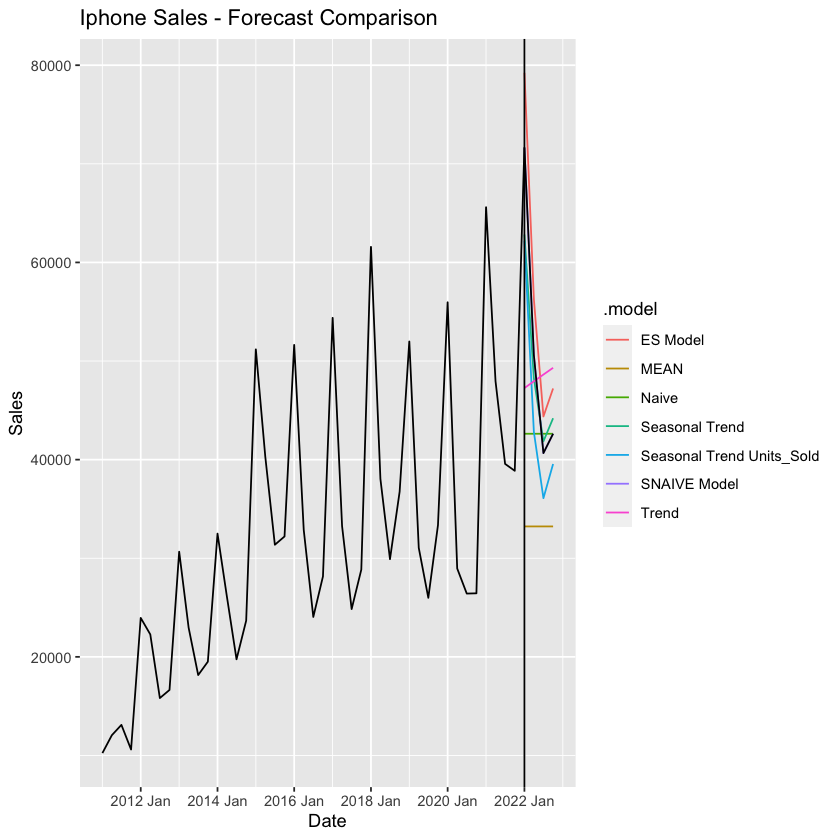

In [46]:
# Plotting the forecast graphs of models
iphone_sales_mdl_forecasts |>
autoplot(level=NULL) +
autolayer(iphone_tr |> filter_index('2011 Jan' ~ .), SALES) +
geom_vline(xintercept = as.Date('2022-01-01')) +
labs(title='Iphone Sales - Forecast Comparison', x='Date', y='Sales')

# Forecasting for 2024

In [47]:
# Forecasting units sold for the future 4 time periods using our best model
iphone_units_sold_mdl_fnl <- updated_iphone_data |>
model(
    'Seasonal Trend' = TSLM(UNITS_SOLD ~ trend() + season()),
) |>
forecast(h = 4) |>
as.data.frame() |>
select(DATE, .mean) |>
rename(UNITS_SOLD = .mean) |>
as_tsibble(index=DATE)

# Displaying the forecast values
iphone_units_sold_mdl_fnl

DATE,UNITS_SOLD
<mth>,<dbl>
2024 Jan,81.06913
2024 Apr,62.17760
2024 Jul,53.52913
2024 Oct,57.37375


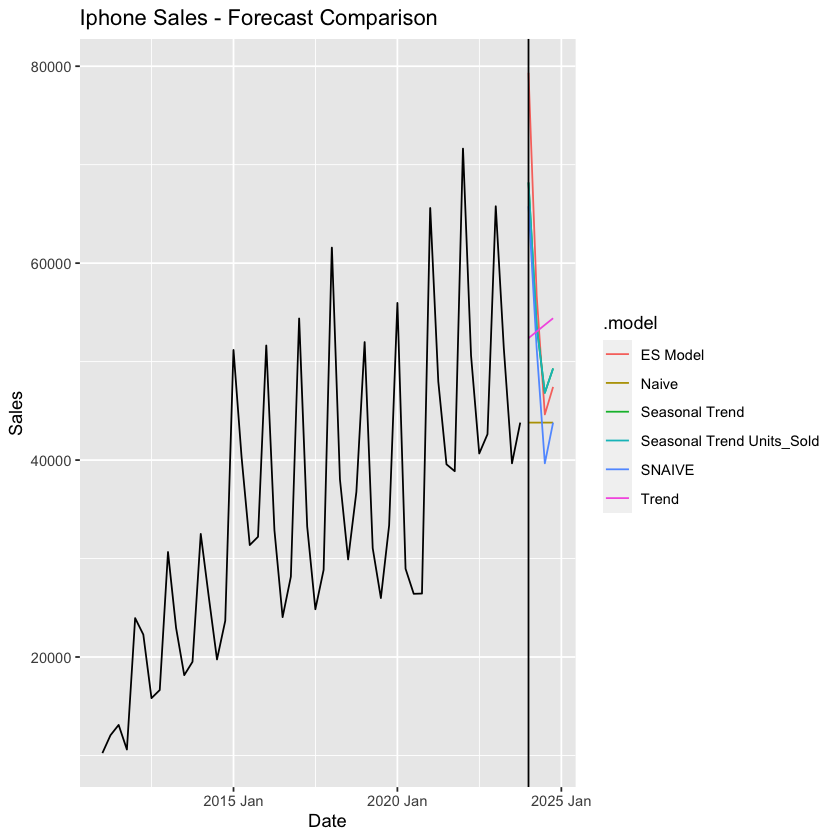

In [48]:
# Forecasting various models for the Iphone Sales for future 2024 
iphone_sales_mdl_full <- updated_iphone_data |>
model(
    'Naive' = NAIVE(SALES),
    'SNAIVE' = SNAIVE(SALES),
    'Trend' = TSLM(SALES ~ trend()),
    'Seasonal Trend' = TSLM(SALES ~ trend() + season()),
    'Seasonal Trend Units_Sold' = TSLM(SALES ~ trend() + season() + UNITS_SOLD),
    'ES Model' = ETS(SALES)
) |>
forecast(iphone_units_sold_mdl_fnl)

# Displaying the graph
iphone_sales_mdl_full |>
autoplot(level=NULL) +
autolayer(updated_iphone_data |> filter_index('2011 Jan' ~ .), SALES) +
geom_vline(xintercept = as.Date('2024-01-01')) +
labs(title='Iphone Sales - Forecast Comparison', x='Date', y='Sales')

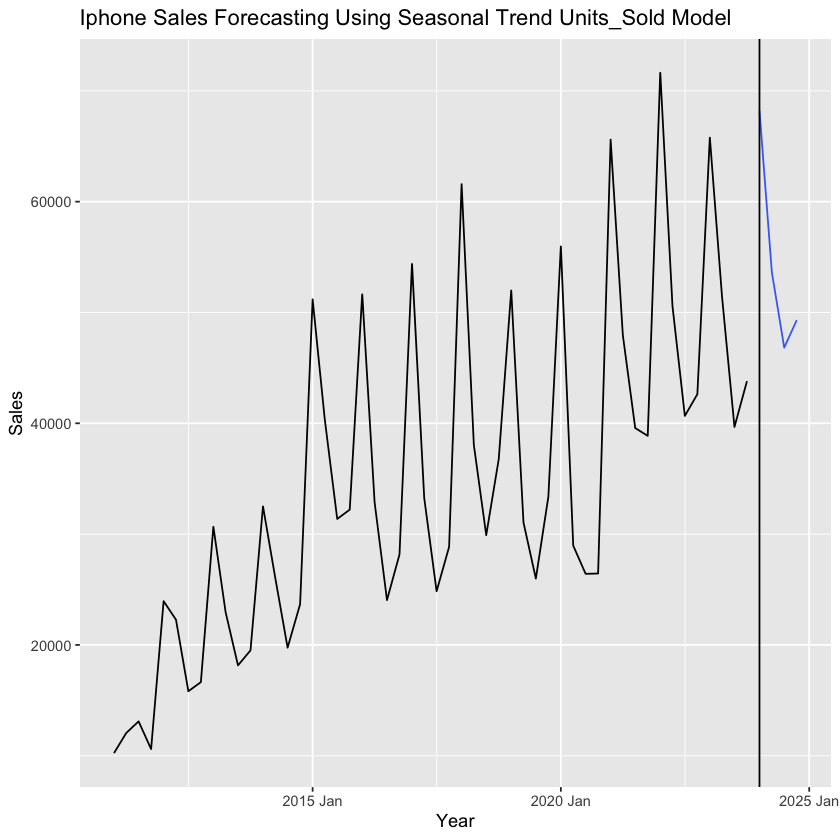

In [49]:
# Displaying the plot of our best forecasting model for Iphone sales forecasting
iphone_sales_mdl_full <- updated_iphone_data |>
model(
    'Seasonal Trend Units_Sold' = TSLM(SALES ~ trend() + season() + UNITS_SOLD),
) |>
forecast(iphone_units_sold_mdl_fnl)

iphone_sales_mdl_full |>
autoplot(level=NULL) +
autolayer(updated_iphone_data |> filter_index('2011 Jan' ~ .), SALES) +
geom_vline(xintercept = as.Date('2024-01-01')) +
labs(title='Iphone Sales Forecasting Using Seasonal Trend Units_Sold Model', x='Year', y='Sales')

# Sensitivity Analysis with 10% increase and 10% decrease in Average Selling price

Grouping structure is ignored.
ℹ `ungroup()` to silence this message.


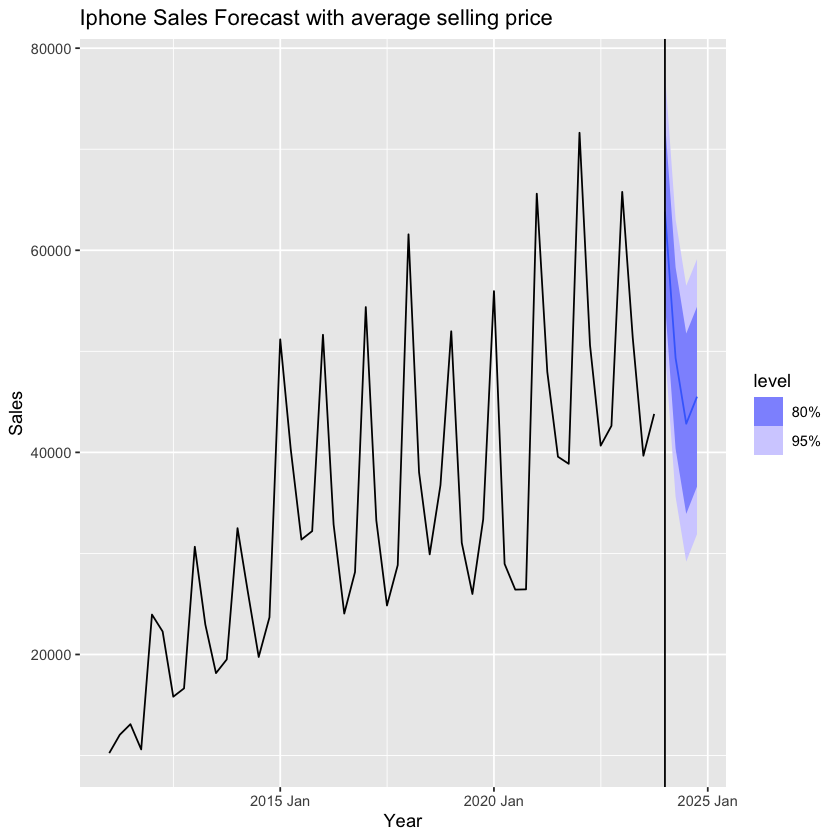

In [50]:
# Fitting the data
fit_iphone_mdl <- updated_iphone_data|>
  model(TSLM(SALES ~ trend() + season() + SALES_PER_UNIT))

# Adding scenarios
new_price <- scenarios(
  "Avg Selling Price" = new_data(updated_iphone_data, 4) |>
    mutate(SALES_PER_UNIT = (mean(updated_iphone_data$SALES_PER_UNIT, na.rm = TRUE) * 1)),
  names_to = "Scenario"
)

# Forecasting with scenarios
fcast <- forecast(fit_iphone_mdl, new_price)

# Displaying the graph
updated_iphone_data |>
  autoplot(SALES) +
  autolayer(fcast) +
  geom_vline(xintercept = as.Date('2024-01-01')) +
  labs(title = "Iphone Sales Forecast with average selling price", y = "Sales", x = "Year")

Grouping structure is ignored.
ℹ `ungroup()` to silence this message.


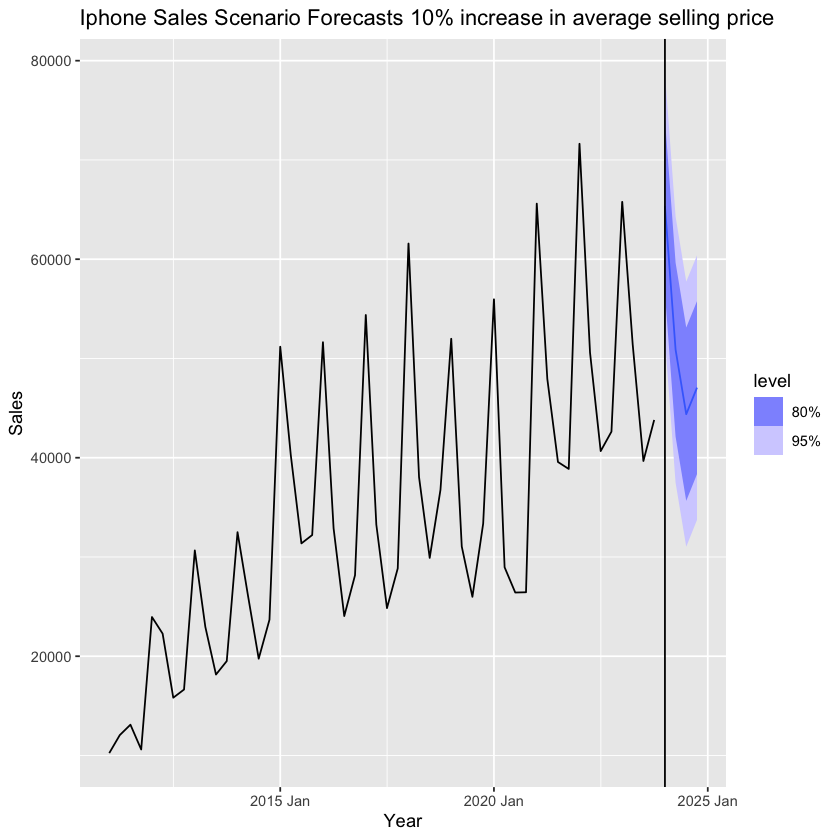

In [51]:
# Fitting the data
fit_iphone_mdl <- updated_iphone_data|>
  model(TSLM(SALES ~ trend() + season() + SALES_PER_UNIT))

# Adding scenarios
new_price <- scenarios(
  "Avg Selling Price Increase 10%" = new_data(updated_iphone_data, 4) |>
    mutate(SALES_PER_UNIT = (mean(updated_iphone_data$SALES_PER_UNIT, na.rm = TRUE) * 1.1)),  # Increase selling price by 10%
  names_to = "Scenario"
)

# Forecasting with scenarios
fcast <- forecast(fit_iphone_mdl, new_price)

# Displaying the graph
updated_iphone_data |>
  autoplot(SALES) +
  autolayer(fcast) +
  geom_vline(xintercept = as.Date('2024-01-01')) +
  labs(title = "Iphone Sales Scenario Forecasts 10% increase in average selling price", y = "Sales", x = "Year")

Grouping structure is ignored.
ℹ `ungroup()` to silence this message.


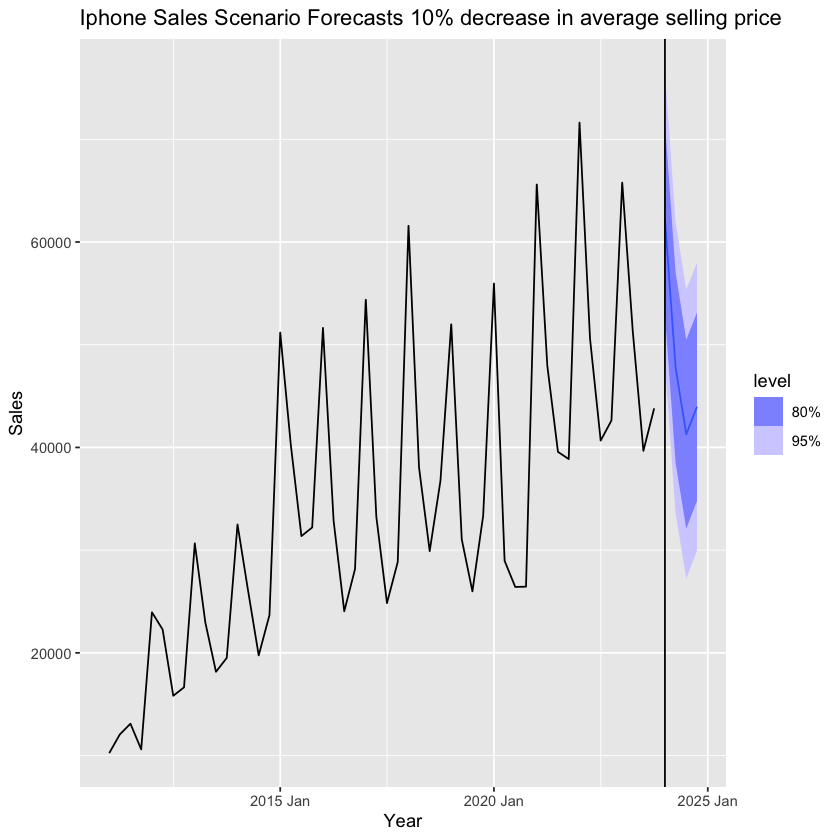

In [52]:
# Fitting the data
fit_iphone_mdl <- updated_iphone_data|>
  model(TSLM(SALES ~ trend() + season() + SALES_PER_UNIT))

# Adding scenarios
new_price <- scenarios(
  "Avg Selling Price Decrease 10%" = new_data(updated_iphone_data, 4) |>
    mutate(SALES_PER_UNIT = (mean(updated_iphone_data$SALES_PER_UNIT, na.rm = TRUE) * 0.9)),  # Decrease selling price by 10%
  names_to = "Scenario"
)

# Forecasting with scenarios
fcast <- forecast(fit_iphone_mdl, new_price)

# Displaying the graph
updated_iphone_data |>
  autoplot(SALES) +
  autolayer(fcast) +
  geom_vline(xintercept = as.Date('2024-01-01')) +
  labs(title = "Iphone Sales Scenario Forecasts 10% decrease in average selling price", y = "Sales", x = "Year")

Grouping structure is ignored.
ℹ `ungroup()` to silence this message.
Grouping structure is ignored.
ℹ `ungroup()` to silence this message.
Grouping structure is ignored.
ℹ `ungroup()` to silence this message.


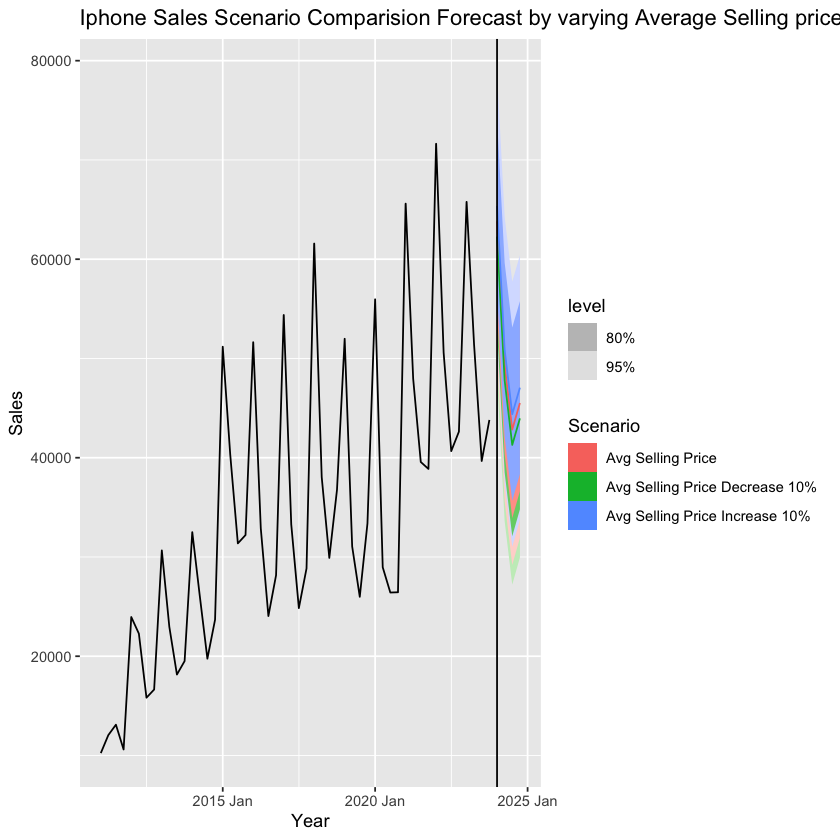

In [53]:
# Fitting the data
fit_iphone_mdl <- updated_iphone_data|>
  model(TSLM(SALES ~ trend() + season() + SALES_PER_UNIT))

# Adding scenarios
new_price <- scenarios(
  "Avg Selling Price" = new_data(updated_iphone_data, 4) |>
    mutate(SALES_PER_UNIT = (mean(updated_iphone_data$SALES_PER_UNIT, na.rm = TRUE) * 1)),
    "Avg Selling Price Increase 10%" = new_data(updated_iphone_data, 4) |>
    mutate(SALES_PER_UNIT = (mean(updated_iphone_data$SALES_PER_UNIT, na.rm = TRUE) * 1.1)),  # Increase selling price by 10%
     "Avg Selling Price Decrease 10%" = new_data(updated_iphone_data, 4) |>
    mutate(SALES_PER_UNIT = (mean(updated_iphone_data$SALES_PER_UNIT, na.rm = TRUE) * 0.9)),  # Decrease selling price by 10%
  names_to = "Scenario"
)

# Forecasting with scenarios
fcast <- forecast(fit_iphone_mdl, new_price)

# Displaying the graph
updated_iphone_data |>
  autoplot(SALES) +
  autolayer(fcast) +
  geom_vline(xintercept = as.Date('2024-01-01')) +
  labs(title = "Iphone Sales Scenario Comparision Forecast by varying Average Selling price", y = "Sales", x = "Year")